<a href="https://colab.research.google.com/github/nerobite/neural_networks/blob/main/Introduction_to_Convolutional_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание. Свёрточные сети

Здесь вам предстоит построить и обучить свою первую свёрточную сеть для классификации изображений на данных CIFAR10.

In [ ]:
import tensorflow as tf

from tqdm.notebook import tqdm

In [ ]:
tf.__version__

'2.14.0'

## Данные

CIFAR10
* 60000 RGB изображений размером 32x32x3
* 10 классов: самолёты, собаки, рыбы и т.п.

<img src="https://www.samyzaf.com/ML/cifar10/cifar1.jpg" style="width:60%">

Загрузите данные, разделите их на обучающую и тестовую выборки. Размер тестовой выборки должен быть $10^4$.

In [ ]:
import numpy as np
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=10**4, random_state=42)

class_names = np.array(['airplane','automobile ','bird ','cat ','deer ','dog ','frog ','horse ','ship ','truck'])

print (X_train.shape,y_train.shape)

170498071/170498071 [==============================] - 3s 0us/step
(40000, 32, 32, 3) (40000, 1)


Прежде чем приступать к основной работе, стоит убедиться что загруженно именно то, что требовалось:

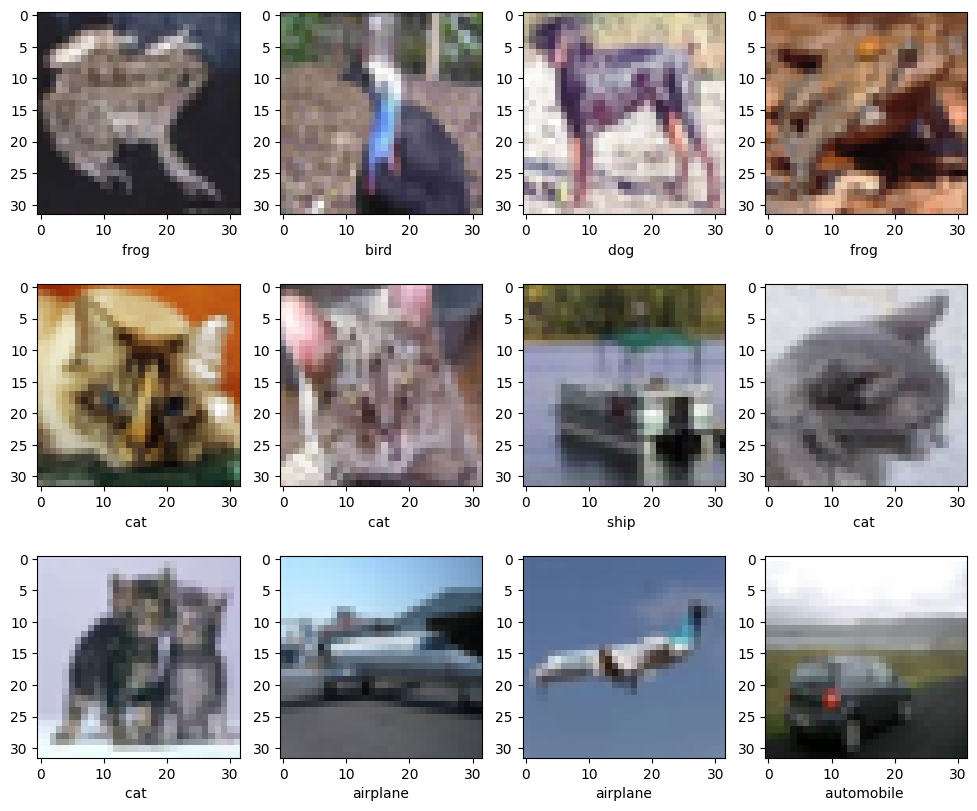

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[12,10])
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.xlabel(class_names[y_train[i, 0]])
    plt.imshow(X_train[i])

## Подготовка данных

Сейчас каждый пиксель изображения закодирован тройкой чисел (RGB) __от 0 до 255__. Однако лучше себя показывает подход, где значения входов нейросети распределены недалеко от 0.

Давайте приведём все данные в диапазон __`[0, 1]`__ — просто разделим на соответствующий коэффициент:

In [ ]:
X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255

In [ ]:
X_train.shape

(40000, 32, 32, 3)

In [ ]:
y_train.shape

(40000, 1)

Исполните код ниже для проверки, что все выполнено корректно.

In [ ]:
assert np.shape(X_train) == (40000, 32, 32, 3), "data shape should not change"
assert 0.9 <= max(map(np.max, (X_train, X_val, X_test))) <= 1.05
assert 0.0 <= min(map(np.min, (X_train, X_val, X_test))) <= 0.1
assert len(np.unique(X_test / 255.)) > 10, "make sure you casted data to float type"

## Архитектура сети

Для начала реализуйте простую нейросеть:
1. принимает на вход картинки размера 32 x 32 x 3;
2. вытягивает их в вектор (`keras.layers.Flatten`);
3. пропускает через 1 или 2 полносвязных слоя;
4. выходной слой отдает вероятности принадлежности к каждому из 10 классов.

Создайте полносвязную сеть:

In [ ]:
import keras
from keras import layers as L
from keras import backend as K

In [ ]:
model = keras.Sequential(
    [
      L.Dense(64, activation="relu", input_shape=(32,32,3,)),
      L.Dropout(0.2),
      L.Dense(32, activation="relu"),
      L.Dropout(0.2),
      L.Dense(32, activation="relu"),
      L.Dropout(0.2),
      L.Flatten(),
      L.Dense(10, activation='softmax'),
    ]
)
model.summary()

Model: "sequential_62"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_217 (Dense)           (None, 32, 32, 64)        256       
                                                                 
 dropout_102 (Dropout)       (None, 32, 32, 64)        0         
                                                                 
 dense_218 (Dense)           (None, 32, 32, 32)        2080      
                                                                 
 dropout_103 (Dropout)       (None, 32, 32, 32)        0         
                                                                 
 dense_219 (Dense)           (None, 32, 32, 32)        1056      
                                                                 
 dropout_104 (Dropout)       (None, 32, 32, 32)        0         
                                                                 
 flatten_75 (Flatten)        (None, 32768)           

In [ ]:
dummy_pred = model.predict(X_train[:20])
assert dummy_pred.shape == (20, 10)
assert np.allclose(dummy_pred.sum(-1), 1)
print("Успех!")

1/1 [==============================] - 0s 227ms/step
Успех!


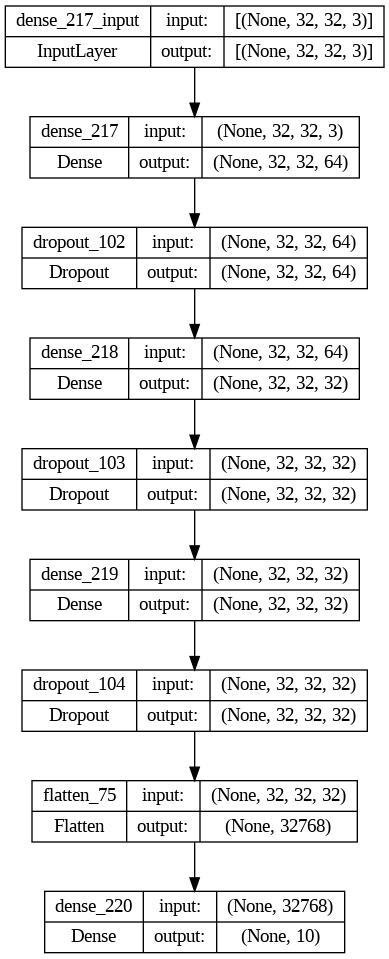

In [ ]:
keras.utils.plot_model(model, 'conv.png', show_shapes=True)

## Обучение сети

**Задание 1.1 (обязательно)** Будем минимизировать многоклассовую кроссэкнропию с помощью __sgd__. Вам нужно получить сеть, которая достигнет __не менее 45%__ __accuracy__ на тестовых данных.

__Важно:__ поскольку в y_train лежат номера классов, Керасу нужно либо указать sparse функции потерь и метрики оценки качества классификации (`sparse_categorical_crossentropy` и `sparse_categorical_accuracy`), либо конвертировать метки в one-hot формат.

### Полезные советы
* `model.compile` позволяет указать, какие метрики вы хотите вычислять.
* В `model.fit` можно передать валидационную выборку (`validation_data=[X_val, y_val]`), для отслеживания прогресса на ней. Также рекомендуем сохранять результаты в [tensorboard](https://keras.io/callbacks/#tensorboard) или [wandb](https://docs.wandb.ai/integrations/jupyter). **Важно: логи tensorboard не получится без боли посмотреть через colab.** Workaround: скачать логи и запустить tensorboard локально или помучаться [с этим](https://stackoverflow.com/questions/47818822/can-i-use-tensorboard-with-google-colab).
* По умолчанию сеть учится 1 эпоху. Совсем не факт, что вам этого хватит. Число эпох можно настроить в методе `fit` (`epochs`).
* Ещё у Кераса есть много [полезных callback-ов](https://keras.io/callbacks/), которые можно попробовать. Например, автоматическая остановка или подбор скорости обучения.

In [ ]:
y_train, y_val = (tf.keras.utils.to_categorical(y) for y in (y_train, y_val))

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.FalseNegatives()])
model.fit(X_train,
          y_train,
          batch_size=32,
          validation_data=[X_val, y_val],
          epochs=10,
          validation_split=0.2)

Epoch 1/10
1250/1250 [==============================] - 123s 97ms/step - loss: 0.2603 - binary_accuracy: 0.9068 - false_negatives_3: 33061.0000 - val_loss: 0.2486 - val_binary_accuracy: 0.9110 - val_false_negatives_3: 7875.0000
Epoch 2/10
1250/1250 [==============================] - 112s 90ms/step - loss: 0.2371 - binary_accuracy: 0.9128 - false_negatives_3: 28865.0000 - val_loss: 0.2351 - val_binary_accuracy: 0.9144 - val_false_negatives_3: 7055.0000
Epoch 3/10
1250/1250 [==============================] - 112s 89ms/step - loss: 0.2292 - binary_accuracy: 0.9157 - false_negatives_3: 27306.0000 - val_loss: 0.2327 - val_binary_accuracy: 0.9151 - val_false_negatives_3: 6768.0000
Epoch 4/10
1250/1250 [==============================] - 121s 97ms/step - loss: 0.2243 - binary_accuracy: 0.9176 - false_negatives_3: 26442.0000 - val_loss: 0.2328 - val_binary_accuracy: 0.9139 - val_false_negatives_3: 6687.0000
Epoch 5/10
1250/1250 [==============================] - 117s 94ms/step - loss: 0.2197 - 

А теперь можно проверить качество вашей сети, выполнив код ниже:

In [ ]:
from sklearn.metrics import accuracy_score

predict_x=model.predict(X_test)
classes_x=np.argmax(predict_x,axis=1)

test_acc = accuracy_score(y_test, classes_x)
print("\n Test_acc =", test_acc)
assert test_acc > 0.45, "Not good enough. Back to the drawing board :)"
print(" Not bad!")

313/313 [==============================] - 6s 17ms/step

 Test_acc = 0.4948
 Not bad!


## Карманная сверточная сеть

**Задание 1.2 (обязательно)** Реализуйте небольшую свёрточную сеть. Совсем небольшую:
1. Входной слой
2. Свёртка 3x3 с 10 фильтрами
3. Нелинейность на ваш вкус
4. Max-pooling 2x2
5. Вытягиваем оставшееся в вектор (Flatten)
6. Полносвязный слой на 100 нейронов
7. Нелинейность на ваш вкус
8. Выходной полносвязный слой с softmax

Обучите её так же, как и предыдущую сеть. Если всё хорошо, у вас получится accuracy не меньше __50%__.

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=10,
                           kernel_size=(3, 3),
                           padding='same',
                           activation='relu',
                           input_shape=X_train.shape[1:]),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),

    tf.keras.layers.Conv2D(filters=32,
                           kernel_size=(3, 3),
                           padding='same',
                           activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),

#######################################

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
dummy_pred = model.predict(X_train[:20])
assert dummy_pred.shape == (20, 10)
assert np.allclose(dummy_pred.sum(-1), 1)
print("Успех!")

1/1 [==============================] - 0s 221ms/step
Успех!


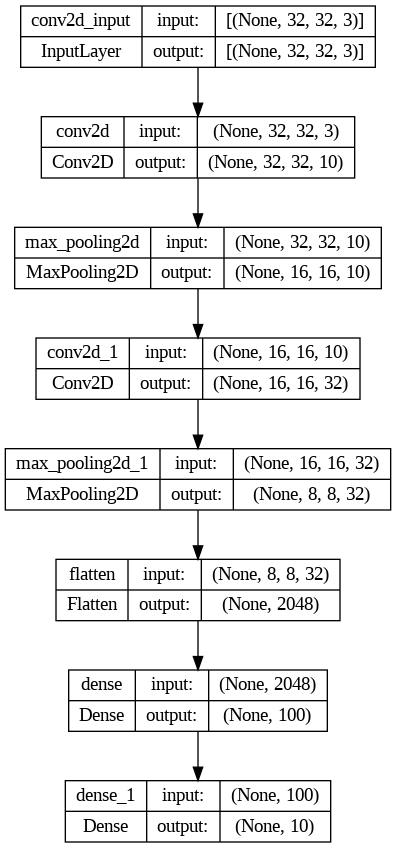

In [ ]:
keras.utils.plot_model(model, 'conv.png', show_shapes=True)

In [ ]:
model.fit(X_train,
          y_train,
          batch_size=32,
          validation_data=[X_val, y_val],
          epochs=10,
          validation_split=0.2)

Epoch 1/10
1250/1250 [==============================] - 49s 38ms/step - loss: 1.5230 - accuracy: 0.4531 - val_loss: 1.2588 - val_accuracy: 0.5567
Epoch 2/10
1250/1250 [==============================] - 40s 32ms/step - loss: 1.1855 - accuracy: 0.5813 - val_loss: 1.1845 - val_accuracy: 0.5865
Epoch 3/10
1250/1250 [==============================] - 37s 30ms/step - loss: 1.0567 - accuracy: 0.6277 - val_loss: 1.0416 - val_accuracy: 0.6389
Epoch 4/10
1250/1250 [==============================] - 40s 32ms/step - loss: 0.9718 - accuracy: 0.6600 - val_loss: 1.0344 - val_accuracy: 0.6421
Epoch 5/10
1250/1250 [==============================] - 40s 32ms/step - loss: 0.9008 - accuracy: 0.6843 - val_loss: 1.0014 - val_accuracy: 0.6575
Epoch 6/10
1250/1250 [==============================] - 37s 30ms/step - loss: 0.8454 - accuracy: 0.7048 - val_loss: 0.9773 - val_accuracy: 0.6604
Epoch 7/10
1250/1250 [==============================] - 39s 31ms/step - loss: 0.7987 - accuracy: 0.7219 - val_loss: 0.9731 -

Давайте посмотрим, смогла ли карманная сверточная сеть побить заданный порог по качеству:

In [ ]:
from sklearn.metrics import accuracy_score

predict_x = model.predict(X_test)
classes_x = np.argmax(predict_x,axis=1)

test_acc = accuracy_score(y_test, classes_x)
print("\n Test_acc =", test_acc)
assert test_acc > 0.50, "Not good enough. Back to the drawing board :)"
print(" Not bad!")

313/313 [==============================] - 3s 9ms/step

 Test_acc = 0.6752
 Not bad!


## Учимся учить

А теперь научимся сравнивать кривые обучения моделей — зависимости значения accuracy от количества итераций.

Вам потребуется реализовать _экспериментальный стенд_ — вспомогательный код, в который вы сможете подать несколько архитектур и методов обучения, чтобы он их обучил и вывел графики кривых обучения. Это можно сделать с помощью `keras.callbacks` — `TensorBoard` или `History`.

Будьте морально готовы, что на обучение уйдёт _много времени_. Даже если вы ограничитесь 10 эпохами. Пока идёт обучение, вы можете переключиться на другие задания или заняться чем-нибудь приятным: поспать, например.

**Задание 1.3 (опционально)** Попробуйте использовать различные методы оптимизации (sgd, momentum, adam) с параметрами по умолчанию. Какой из методов работает лучше?

Для удобства напишем класс Evaluator, который принимает в себя дикты виды {имя_оптимайзера: инстанс}, {имя модели: инстанс} и обучает всевозможные комбинации моделей с оптимайзерами при помощи метода fit (попутно записывая логи отдельно для каждой модели). Также пригодится метод evaluate для отображения итоговых скоров.

Пользоваться классом не обязательно. По умолчанию класс использует tensorboard. Если вы выше использовали wandb -- советуем дописать callback.

In [ ]:
class Evaluator(list):
    def __init__(self, models, optimizers='adam', loss=keras.losses.categorical_crossentropy,
                 metrics=[keras.metrics.categorical_accuracy]):
        '''
            models: dict {name: model}
            optimizers: list of optimizers or just one optimizer
        '''
        if not isinstance(models, dict):
            models = {'single_model': models}
        if not isinstance(optimizers, dict):
            optimizers = {str(optimizers.__class__): optimizers}
        super().__init__([(model_name, keras.models.clone_model(model), optimizer_name, optimizer)
                          for model_name, model in models.items()
                          for optimizer_name, optimizer in optimizers.items()])
        for _, model, _, optimizer in self:
            model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    def fit(self, X, y, validation_data=(), max_epochs=100, verbose=0, callbacks=[], batch_size=32):
        if not isinstance(callbacks, list):
            callbacks = [callbacks]
        for model_name, model, optimizer_name, optimizer in tqdm(self):
            model.fit(X, y, validation_data=validation_data or None, epochs=max_epochs, verbose=verbose,
                      batch_size=batch_size, callbacks=callbacks + [keras.callbacks.TensorBoard(
                          log_dir='./logs/{}_{}'.format(model_name, optimizer_name))])

    def fit_generator(self, X, y, validation_data=(), max_epochs=100, verbose=1, callbacks=[], batch_size=32):
        datagen = keras.preprocessing.image.ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True
        )
        if not isinstance(callbacks, list):
            callbacks = [callbacks]
        for model_name, model, optimizer_name, optimizer in tqdm(self):
            model.fit_generator(datagen.flow(X, y, batch_size=batch_size), epochs=max_epochs,
                validation_data=validation_data or None, verbose=verbose,
                callbacks=callbacks + [keras.callbacks.TensorBoard(
                    log_dir='./logs/{}_{}'.format(model_name, optimizer_name))])

    def evaluate(self, X, y, metric):
        for model_name, model, optimizer_name, _ in self:
            print('Final score of {}_{} is {}'.format(model_name, optimizer_name,
                  metric(y_test, np.argmax(model.predict(X_test), axis=-1))))

In [ ]:
!rm -rf ./logs

In [ ]:
# optimizers = {
#     # 'optimizer_name': optimizer
# }

from tensorflow.keras import optimizers
optimizers = { 'SGD': optimizers.SGD(),
               'Adam': optimizers.Adam()
              }

In [ ]:
evaluator = Evaluator(model, optimizers=optimizers)
evaluator.fit(X_train, y_train, validation_data=(X_val, y_val))
evaluator.evaluate(X_test, y_test, accuracy_score)

  0%|          | 0/2 [00:00<?, ?it/s]

313/313 [==============================] - 3s 10ms/step
Final score of single_model_SGD is 0.6481
313/313 [==============================] - 4s 12ms/step
Final score of single_model_Adam is 0.6231


Прокомментируйте полученные результаты.

In [ ]:
#Как бы это не было странно, но стохастический градиентный спуск показал лучше результат чем оптимизатор Adam, и отработал он быстрее, поэтому рано ставить крест на SGD
# и не Adam'ом едины и при наличии возможности, лучше проверять разные потимизаторы для разных моделей.


**Задание 1.4 (опционально)** Добавьте нормализацию по батчу (`BatchNormalization`) между свёрткой и активацией. Попробуйте использовать несколько нормализаций — в свёрточных и полносвязных слоях.

Для удобства реализуем класс Models, который по сути будет являться списком моделей с двумя методами: add (добавить слой ко всем моделям) и add_create (создать новую модель на основе базовой с дополнительным слоем). Пользоваться им необязательно, но вдруг :)

In [ ]:
from collections import OrderedDict

class Models(OrderedDict):
    def __init__(self, models):
        if not isinstance(models, dict):
            models = OrderedDict({'base_model': models})
        super().__init__(models)

    def add(self, layer):
        for name, model in self.items():
            model.add(layer)

    def add_create(self, name, layer):
        base_model = next(iter(self.items()))[1]
        new_model = keras.models.clone_model(base_model)
        new_model.add(layer)
        self.update({name: new_model})

    def add_update(self, name, layer):
        base_model = self[next(reversed(self))]
        new_model = keras.models.clone_model(base_model)
        new_model.add(layer)
        self.update({name: new_model})

# Example of usage

# ...

In [ ]:
models = Models(keras.Sequential())
models.add(L.InputLayer(input_shape=(32, 32, 3)))
models.add(L.Convolution2D(filters=10, kernel_size=(3, 3)))
models.add(L.MaxPooling2D())
models.add_create('conv_batchnorm', L.BatchNormalization())
models.add(L.Activation('relu'))
models.add(L.InputLayer(input_shape=(32, 32, 3)))
models.add(L.Convolution2D(filters=64, kernel_size=(3, 3)))
models.add(L.MaxPooling2D())
models.add_create('conv_batchnorm', L.BatchNormalization())
models.add(L.Activation('relu'))
models.add(L.Convolution2D(filters=32, kernel_size=(3, 3)))
models.add(L.MaxPooling2D())
models.add_create('conv_batchnorm', L.BatchNormalization())
models.add(L.Activation('relu'))
models.add(L.Activation('softmax'))

In [ ]:
#Не понял как работать с этим классом и чего делать?

In [ ]:
model_b = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=10,
                           kernel_size=(3, 3),
                           padding='same',
                           activation='relu',
                           input_shape=X_train.shape[1:]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),

    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=32,
                           kernel_size=(3, 3),
                           padding='same',
                           activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),

#######################################

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')])

model_b.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model_b.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 32, 32, 10)        280       
                                                                 
 batch_normalization_37 (Ba  (None, 32, 32, 10)        40        
 tchNormalization)                                               
                                                                 
 max_pooling2d_44 (MaxPooli  (None, 16, 16, 10)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_38 (Ba  (None, 16, 16, 10)        40        
 tchNormalization)                                               
                                                                 
 conv2d_45 (Conv2D)          (None, 16, 16, 32)        2912      
                                                     

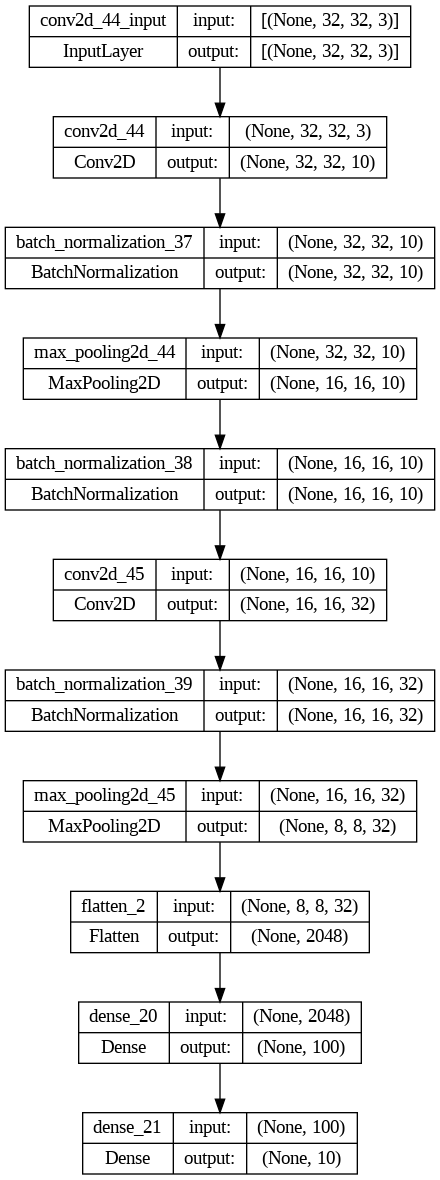

In [ ]:
keras.utils.plot_model(model_b, 'conv1.png', show_shapes=True)

In [ ]:
model_b.fit(X_train,
          y_train,
          batch_size=32,
          validation_data=[X_val, y_val],
          epochs=10,
          validation_split=0.2)

Epoch 1/10
1250/1250 [==============================] - 58s 46ms/step - loss: 1.5480 - accuracy: 0.4471 - val_loss: 1.3273 - val_accuracy: 0.5248
Epoch 2/10
1250/1250 [==============================] - 57s 45ms/step - loss: 1.2127 - accuracy: 0.5694 - val_loss: 1.1773 - val_accuracy: 0.5815
Epoch 3/10
1250/1250 [==============================] - 61s 49ms/step - loss: 1.0659 - accuracy: 0.6214 - val_loss: 1.1691 - val_accuracy: 0.5846
Epoch 4/10
1250/1250 [==============================] - 64s 51ms/step - loss: 0.9677 - accuracy: 0.6575 - val_loss: 1.1717 - val_accuracy: 0.5958
Epoch 5/10
1250/1250 [==============================] - 57s 45ms/step - loss: 0.8896 - accuracy: 0.6885 - val_loss: 1.0857 - val_accuracy: 0.6237
Epoch 6/10
1250/1250 [==============================] - 56s 45ms/step - loss: 0.8217 - accuracy: 0.7111 - val_loss: 1.0700 - val_accuracy: 0.6293
Epoch 7/10
1250/1250 [==============================] - 58s 46ms/step - loss: 0.7578 - accuracy: 0.7339 - val_loss: 1.1629 -

In [ ]:
predict_x = model.predict(X_test)
classes_x = np.argmax(predict_x,axis=1)

test_acc = accuracy_score(y_test, classes_x)
print("\n Test_acc =", test_acc)
assert test_acc > 0.50, "Not good enough. Back to the drawing board :)"
print(" Not bad!")

313/313 [==============================] - 3s 10ms/step

 Test_acc = 0.6747
 Not bad!


Прокомментируйте полученные результаты.

**Задание 1.5 (опционально)** Посмотрите на batch_size (параметр model.fit) - при большем батче модель будет быстрее проходить эпохи, но с совсем огромным батчом вам потребуется больше эпох для сходимости (т.к. сеть делает меньше шагов за одну эпоху).
Найдите такое значение, при котором модель быстрее достигает точности 55%. **Hint**: используйте early stopping callback.

In [ ]:
model.fit(X_train,
          y_train,
          batch_size=128,
          validation_data=[X_val, y_val],
          epochs=10,
          validation_split=0.2)

Epoch 1/10
313/313 [==============================] - 38s 120ms/step - loss: 0.5439 - accuracy: 0.8123 - val_loss: 0.9835 - val_accuracy: 0.6847
Epoch 2/10
313/313 [==============================] - 33s 105ms/step - loss: 0.5261 - accuracy: 0.8188 - val_loss: 0.9992 - val_accuracy: 0.6810
Epoch 3/10
313/313 [==============================] - 56s 181ms/step - loss: 0.5145 - accuracy: 0.8224 - val_loss: 1.0021 - val_accuracy: 0.6818
Epoch 4/10
313/313 [==============================] - 42s 134ms/step - loss: 0.4998 - accuracy: 0.8250 - val_loss: 1.0155 - val_accuracy: 0.6834
Epoch 5/10
313/313 [==============================] - 34s 109ms/step - loss: 0.4852 - accuracy: 0.8323 - val_loss: 1.0449 - val_accuracy: 0.6774
Epoch 6/10
313/313 [==============================] - 46s 147ms/step - loss: 0.4714 - accuracy: 0.8367 - val_loss: 1.0717 - val_accuracy: 0.6761
Epoch 7/10
313/313 [==============================] - 33s 106ms/step - loss: 0.4578 - accuracy: 0.8413 - val_loss: 1.0939 - val_ac

In [ ]:
predict_x = model.predict(X_test)
classes_x = np.argmax(predict_x,axis=1)

test_acc = accuracy_score(y_test, classes_x)
print("\n Test_acc =", test_acc)
assert test_acc > 0.50, "Not good enough. Back to the drawing board :)"
print(" Not bad!")

313/313 [==============================] - 5s 14ms/step

 Test_acc = 0.6721
 Not bad!


In [ ]:
model.fit(X_train,
          y_train,
          batch_size=512,
          validation_data=[X_val, y_val],
          epochs=10,
          validation_split=0.2)

Epoch 1/10
79/79 [==============================] - 31s 389ms/step - loss: 0.3381 - accuracy: 0.8910 - val_loss: 1.1662 - val_accuracy: 0.6767
Epoch 2/10
79/79 [==============================] - 31s 388ms/step - loss: 0.3243 - accuracy: 0.8968 - val_loss: 1.1926 - val_accuracy: 0.6762
Epoch 3/10
79/79 [==============================] - 30s 387ms/step - loss: 0.3185 - accuracy: 0.8995 - val_loss: 1.1951 - val_accuracy: 0.6732
Epoch 4/10
79/79 [==============================] - 30s 381ms/step - loss: 0.3110 - accuracy: 0.9025 - val_loss: 1.2076 - val_accuracy: 0.6750
Epoch 5/10
79/79 [==============================] - 40s 504ms/step - loss: 0.3042 - accuracy: 0.9059 - val_loss: 1.2270 - val_accuracy: 0.6714
Epoch 6/10
79/79 [==============================] - 35s 447ms/step - loss: 0.3004 - accuracy: 0.9059 - val_loss: 1.2428 - val_accuracy: 0.6723
Epoch 7/10
79/79 [==============================] - 38s 478ms/step - loss: 0.2947 - accuracy: 0.9076 - val_loss: 1.2601 - val_accuracy: 0.6732

In [ ]:
predict_x = model.predict(X_test)
classes_x = np.argmax(predict_x,axis=1)

test_acc = accuracy_score(y_test, classes_x)
print("\n Test_acc =", test_acc)
assert test_acc > 0.50, "Not good enough. Back to the drawing board :)"
print(" Not bad!")

313/313 [==============================] - 3s 9ms/step

 Test_acc = 0.6691
 Not bad!


In [ ]:
model.fit(X_train,
          y_train,
          batch_size=2048,
          validation_data=[X_val, y_val],
          epochs=10,
          validation_split=0.2)

Epoch 1/10
20/20 [==============================] - 32s 2s/step - loss: 0.2635 - accuracy: 0.9218 - val_loss: 1.3209 - val_accuracy: 0.6721
Epoch 2/10
20/20 [==============================] - 32s 2s/step - loss: 0.2496 - accuracy: 0.9289 - val_loss: 1.3199 - val_accuracy: 0.6698
Epoch 3/10
20/20 [==============================] - 31s 2s/step - loss: 0.2455 - accuracy: 0.9302 - val_loss: 1.3278 - val_accuracy: 0.6713
Epoch 4/10
20/20 [==============================] - 31s 2s/step - loss: 0.2426 - accuracy: 0.9312 - val_loss: 1.3367 - val_accuracy: 0.6694
Epoch 5/10
20/20 [==============================] - 31s 2s/step - loss: 0.2406 - accuracy: 0.9327 - val_loss: 1.3400 - val_accuracy: 0.6720
Epoch 6/10
20/20 [==============================] - 31s 2s/step - loss: 0.2396 - accuracy: 0.9323 - val_loss: 1.3466 - val_accuracy: 0.6687
Epoch 7/10
20/20 [==============================] - 31s 2s/step - loss: 0.2381 - accuracy: 0.9334 - val_loss: 1.3520 - val_accuracy: 0.6673
Epoch 8/10
20/20 [==

In [ ]:
predict_x = model.predict(X_test)
classes_x = np.argmax(predict_x,axis=1)

test_acc = accuracy_score(y_test, classes_x)
print("\n Test_acc =", test_acc)
assert test_acc > 0.50, "Not good enough. Back to the drawing board :)"
print(" Not bad!")

313/313 [==============================] - 5s 16ms/step

 Test_acc = 0.6746
 Not bad!


In [ ]:
#Скорость не намного учеличалась у увеличением батча, но метрика подросла))

**Задание 1.6 (опционально)** Попробуйте найти такую комбинацию метода обучения и нормализации, при которой сеть имеет наилучшую кривую обучения. Поясните, что вы понимаете под "наилучшей" кривой обучения.

## Свёрточная нейросеть здорового человека

**Задание 1.7 (обязательно попытаться)** Наигравшись выше, обучим большую свёрточную сеть, которая даст на тестовой выборке __accuracy больше 80%__. В этом задании вам потребуется провести эксперименты, сравнив их между собой в конце. Возможно, может быть несколько проще, если писать выводы во время или сразу после каждого эксперимента, после чего сделать общие выводы.

Рекомендуем начать с лучшей модели предыдущего задания и постепенно её улучшать. Вы можете использовать всё, что угодно: любые активации, сколь угодно большие свёрточные слои и глубокие сети. Единственное ограничение: __нельзя использовать предобученные сети и дополнительные данные__.

### Полезные советы
* Для начала, неплохо бы научить что-нибудь побольше, чем 10 фильтров 3x3.
* __Главное правило: одно изменение на эксперимент__. Если у вас есть 2 идеи по улучшению сети, сначала попробуйте их независимо. Может оказаться, что одно из них дало __+10%__ точности а другое __-7%__. А вы так и будете думать, что сделали 2 полезных изменения которые в сумме дают __+3%__. Если какая-то идея не работает — даже если она вам нравится - опишите ее и выкидывайте из дальнейших экспериментов.
* __Be careful or you will dropout__. Дропаут (`L.Dropout`) может позволить вам обучить в несколько раз бОльшую сеть без переобучения, выжав несколько процентов качества. Это круто, но не стоит сразу ставить dropout 50%. Во-первых, слишком сильный дропаут только ухудшит сеть (underfitting). Во-вторых, даже если дропаут улучшает качество, он замедляет обучение. Рекомендуем начинать с небольшого дропаута, быстро провести основные эксперименты, а потом жахнуть в 2 раза больше нейронов и дропаута ~~на ночь~~.
* __Аугментация данных__. Если котика слегка повернуть и подрезать (простите), он всё равно останется котиком. А в керасе есть [удобный класс](https://keras.io/preprocessing/image/), который поставит подрезание котиков на поток. Ещё можно сделать этот трюк в тесте: вертим картинку 10 раз, предсказываем вероятности и усредняем. Только один совет: прежде, чем учить, посмотрите глазами на аугментированные картинки. Если вы сами не можете их различить, то и сеть не сможет.
* __Don't just stack more layers__. Есть более эффективные способы организовать слои, чем простой Sequential. Вот пара идей: [Inception family](https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/), [ResNet family](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035?gi=9018057983ca), [Densely-connected convolutions](https://arxiv.org/abs/1608.06993). Только не копируйте архитектуру подчистую — вам скорее всего хватит меньшего размера.
* __Долго != плохо__. Более глубокие архитектуры обычно требуют бОльше эпох до сходимости. Это значит, что в первые несколько эпох они могут быть хуже менее глубоких аналогов. Дайте им время, запаситесь чаем и обмажьтесь batch-norm-ом.

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=256,
                           kernel_size=(9, 9),
                           padding='same',
                           activation='relu',
                           input_shape=X_train.shape[1:]),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),


    tf.keras.layers.Conv2D(filters=256,
                           kernel_size=(3, 3),
                           padding='same',
                           activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),

#######################################

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 256)       62464     
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 256)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 512)       1180160   
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 512)         0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 256)               8

In [ ]:
model.fit(X_train,
          y_train,
          batch_size=2048,
          callbacks = callbacks,
          validation_data=[X_val, y_val],
          epochs=10,
          validation_split=0.5)

Epoch 1/10
20/20 [==============================] - ETA: 0s - loss: 2.2374 - accuracy: 0.1804  

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 2459s 123s/step - loss: 2.2374 - accuracy: 0.1804 - val_loss: 2.1642 - val_accuracy: 0.2416
Epoch 2/10
20/20 [==============================] - 2358s 118s/step - loss: 1.9208 - accuracy: 0.3148 - val_loss: 1.7681 - val_accuracy: 0.3717
Epoch 3/10
20/20 [==============================] - 2416s 121s/step - loss: 1.6510 - accuracy: 0.4181 - val_loss: 1.5730 - val_accuracy: 0.4454
Epoch 4/10
20/20 [==============================] - 2365s 119s/step - loss: 1.5011 - accuracy: 0.4674 - val_loss: 1.4613 - val_accuracy: 0.4782
Epoch 5/10
20/20 [==============================] - 2427s 121s/step - loss: 1.4328 - accuracy: 0.4936 - val_loss: 1.3898 - val_accuracy: 0.5116
Epoch 6/10
20/20 [==============================] - 2433s 122s/step - loss: 1.3378 - accuracy: 0.5299 - val_loss: 1.3441 - val_accuracy: 0.5279
Epoch 7/10
20/20 [==============================] - 2463s 124s/step - loss: 1.2671 - accuracy: 0.5548 - val_loss: 1.3361 - val_accuracy: 0.5280
Epo

Момент истины: проверьте, какого качества достигла ваша сеть.

In [ ]:
from sklearn.metrics import accuracy_score

predict_x=model.predict(X_test)
classes_x=np.argmax(predict_x,axis=1)

test_acc = accuracy_score(y_test, classes_x)
print("\n Test_acc =", test_acc)
if test_acc > 0.8:
    print("Это победа!")

313/313 [==============================] - 159s 506ms/step

 Test_acc = 0.5948


In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=64,
                           kernel_size=(3, 3),
                           padding='same',
                           activation='relu',
                           input_shape=X_train.shape[1:]),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),


    tf.keras.layers.Conv2D(filters=256,
                           kernel_size=(3, 3),
                           padding='same',
                           activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),

#######################################

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 16, 16, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (None, 16, 16, 256)       147712    
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 8, 8, 256)         0         
 ng2D)                                                           
                                                                 
 flatten_8 (Flatten)         (None, 16384)             0         
                                                                 
 dense_16 (Dense)            (None, 128)              

In [ ]:
model.fit(X_train,
          y_train,
          batch_size=16,
          validation_data=[X_val, y_val],
          epochs=12,
          validation_split=0.2)

Epoch 1/12
2500/2500 [==============================] - 394s 157ms/step - loss: 1.3371 - accuracy: 0.5222 - val_loss: 1.0533 - val_accuracy: 0.6273
Epoch 2/12
2500/2500 [==============================] - 376s 150ms/step - loss: 0.9544 - accuracy: 0.6678 - val_loss: 0.9836 - val_accuracy: 0.6585
Epoch 3/12
2500/2500 [==============================] - 362s 145ms/step - loss: 0.7945 - accuracy: 0.7232 - val_loss: 0.8742 - val_accuracy: 0.6999
Epoch 4/12
2500/2500 [==============================] - 376s 150ms/step - loss: 0.6671 - accuracy: 0.7684 - val_loss: 0.8485 - val_accuracy: 0.7081
Epoch 5/12
2500/2500 [==============================] - 348s 139ms/step - loss: 0.5540 - accuracy: 0.8062 - val_loss: 0.9145 - val_accuracy: 0.7042
Epoch 6/12
2500/2500 [==============================] - 339s 136ms/step - loss: 0.4519 - accuracy: 0.8407 - val_loss: 0.9573 - val_accuracy: 0.7084
Epoch 7/12
2500/2500 [==============================] - 342s 137ms/step - loss: 0.3661 - accuracy: 0.8693 - val_

In [ ]:
from sklearn.metrics import accuracy_score

predict_x=model.predict(X_test)
classes_x=np.argmax(predict_x,axis=1)

test_acc = accuracy_score(y_test, classes_x)
print("\n Test_acc =", test_acc)
if test_acc > 0.8:
    print("Это победа!")

313/313 [==============================] - 22s 69ms/step

 Test_acc = 0.6797


А теперь, опишите свои <s>ощущения</s> результаты от проведенных экспериментов.

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=64,
                           kernel_size=(3, 3),
                           padding='same',
                           activation='relu',
                           input_shape=X_train.shape[1:]),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),


    tf.keras.layers.SeparableConv2D(filters=1024,
                           kernel_size=(3, 3),
                           padding='same',
                           activation='relu'),
    tf.keras.layers.GlobalMaxPooling2D(),

#######################################

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 16, 16, 64)        0         
 ng2D)                                                           
                                                                 
 separable_conv2d_8 (Separa  (None, 16, 16, 1024)      67136     
 bleConv2D)                                                      
                                                                 
 global_max_pooling2d_2 (Gl  (None, 1024)              0         
 obalMaxPooling2D)                                               
                                                                 
 flatten_11 (Flatten)        (None, 1024)              0         
                                                     

In [ ]:
model.fit(X_train,
          y_train,
          batch_size=32,
          validation_data=[X_val, y_val],
          epochs=10,
          validation_split=0.2)

Epoch 1/10
1250/1250 [==============================] - 259s 207ms/step - loss: 1.7123 - accuracy: 0.3615 - val_loss: 1.4285 - val_accuracy: 0.4771
Epoch 2/10
1250/1250 [==============================] - 259s 207ms/step - loss: 1.3362 - accuracy: 0.5144 - val_loss: 1.2217 - val_accuracy: 0.5598
Epoch 3/10
1250/1250 [==============================] - 272s 217ms/step - loss: 1.1584 - accuracy: 0.5809 - val_loss: 1.1203 - val_accuracy: 0.5973
Epoch 4/10
1250/1250 [==============================] - 276s 221ms/step - loss: 1.0431 - accuracy: 0.6289 - val_loss: 1.0302 - val_accuracy: 0.6402
Epoch 5/10
1250/1250 [==============================] - 266s 213ms/step - loss: 0.9494 - accuracy: 0.6607 - val_loss: 0.9812 - val_accuracy: 0.6505
Epoch 6/10
1250/1250 [==============================] - 269s 215ms/step - loss: 0.8756 - accuracy: 0.6866 - val_loss: 0.9089 - val_accuracy: 0.6807
Epoch 7/10
1250/1250 [==============================] - 271s 217ms/step - loss: 0.8149 - accuracy: 0.7109 - val_

In [ ]:
from sklearn.metrics import accuracy_score

predict_x=model.predict(X_test)
classes_x=np.argmax(predict_x,axis=1)

test_acc = accuracy_score(y_test, classes_x)
print("\n Test_acc =", test_acc)
if test_acc > 0.8:
    print("Это победа!")

313/313 [==============================] - 23s 74ms/step

 Test_acc = 0.6891
